# Improving GME gradient computation efficiency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PhC cavity simulation

We will look at a cavity simulation similar to the previous Notebook and see how it can be improved both in terms of accuracy and in terms of computational time and memory. We first define the cavity that we will simulate. This time we use a silicon slab in air because of the larger photonic band gap. This will come in handy later.

In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 10

# Regular PhC parameters
ra = 0.25
dslab = 0.5
n_slab = 3.48

# Initialize a lattice and PhC
lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Move the first two holes to create the L4/3 defect
xp[0] = 2/5
xp[1] = 6/5 
nc = len(xp)

# Initialize shift parameters to zeros
dx, dy = np.zeros((nc,)), np.zeros((nc,))

In [3]:
# Define L4/3 PhC cavity with shifted holes
def cavity(dx, dy):
    # Initialize PhC
    phc = legume.PhotCryst(lattice)
    
    # Add a layer to the PhC 
    phc.add_layer(d=dslab, eps_b=n_slab**2)
    
    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic] if yp[ic] == 0 else yp[ic] + dy[ic]
        xc = x if x == 0 else xp[ic] + dx[ic]
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
        if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
        if nx-1.6 > xp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
        if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
            phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))
            
    return phc

In the previous example, we used a relatively fast optimization for illustration purposes. In the `legume` paper, we use `gmax = 2.5`, as well as a 3x3 $k$-grid in the Brillouin zone, and average the loss rates. This improves the accuracy of the result, especially when going to ultra-high-$Q$ values. However, it also takes a longer time to compute, and significantly more memory if done directly, because all the variables, including all the dense matrices and all the eigenvectors at every $k$ are stored for the backpropagation. We will see how we can introduce some improvements.

Below, we define a new GME computation function, with two main differences from the previous Notebook. First, we compute the loss rates on a grid of $k$-points. Second, instead of taking the `Nx*Ny` eigenmode as the cavity mode, we look for the first eigenfrequency above 0.26 (first mode in the band gap). The reason for this will become clear below.

In [11]:
def gme_cavity_k(dx, dy, gmax, options, kpoints, f_lb=0.26):
    phc = cavity(dx, dy)
    options['compute_im'] = False
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    gme.run(kpoints=kpoints, **options)
    indmode = npa.nonzero(gme.freqs[0, :] > f_lb)[0][0]
    fims = []
    for ik in range(kpoints[0, :].size):
        (freq_im, _, _) = gme.compute_rad(ik, [indmode])
        fims.append(freq_im)
    print(gme.gvec.shape)
    return (gme, npa.array(fims), indmode)

## Accuracy of forward computation
We first compare the quality factor computed at a single $k$-point to the one computed after averaging over a small grid in $k$-space. To speed things up here, we'll only use `gmax = 1.5` and a 2x2 grid in $k$. Note that it's better to average the loss rates and only then compute the $Q$, rather than average the $Q$-s. 

Instead of computing `Nx*Ny` modes like before, here we will only compute 5 modes closes to $f=0.28$, which is where we expect the cavity mode to lie (we've checked in a previous simulation). When using the default solver, `numpy.linalg.eigh`, this actually doesn't make any difference, because *all* the eigenmodes are computed, but only the requested ones are stored. However, below we will also test using the `scipy.sparse.linagl.eigsh` solver, which only computes the requested number `numeig` of eigenmodes. 

7.9343s total time for real part of frequencies, of which
  0.7828s for guided modes computation using the gmode_compute='exact' method
  0.2510s for inverse matrix of Fourier-space permittivity
  3.9697s for matrix diagionalization using the 'eigh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
(2, 1225)
Cavity quality factor at k=0:             16346.40
Quality factor averaged over 4 k-points:  29026.16


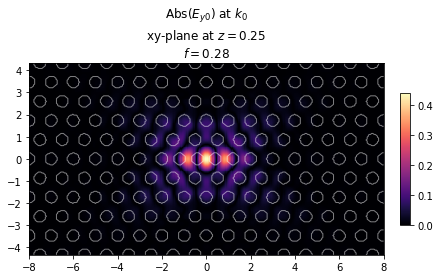

In [12]:
# Set some GME options
options = {'gmode_inds': [0], 'verbose': True, 'gradients': 'approx',
           'numeig': 5,       # get 5 eigenvalues
           'eig_sigma': 0.28  # closest to f = 0.28
          }
gmax = 1.5

# Create a grid in k space (non-negative kx, ky only)
nkx = 2
nky = 2
kx = np.linspace(0, np.pi/Nx, nkx)
ky = np.linspace(0, np.pi/Ny/np.sqrt(3)*2, nky)
kxg, kyg = np.meshgrid(kx, ky)
kxg = kxg.ravel()
kyg = kyg.ravel()

# Run the simulation for the starting cavity (zero shifts as initialized above)
(gme, fims, indmode) = gme_cavity_k(dx, dy, gmax=gmax, options=options, kpoints=np.vstack((kxg, kyg)))
# Print the computed quality factor
print("Cavity quality factor at k=0:             %1.2f" %(gme.freqs[0, indmode]/2/fims[0]))
print("Quality factor averaged over %d k-points:  %1.2f" %(nkx*nky, gme.freqs[0, indmode]/2/np.mean(fims)))

# We can also visualize the cavity and the mode profile of the fundamental mode
ax = legume.viz.field(gme, 'e', 0, indmode, z=dslab/2, component='y', val='abs', N1=300, N2=200)

There is obviously a difference in the computed $Q$, and this can become exacerbated for designs that are optimized at just a single $k$-point. Thus, it is important to do some averaging, and fortunately in our experience just a small grid is sufficient. 

## Time and memory requirements for gradient computation

Now we will compare several different ways to compute the gradient of the $k$-averaged loss rates. We measure the memory using the magic function from the [memory profiler](https://pypi.org/project/memory-profiler/), which you should have installed to run the cells below (or comment out the `%memit` commands).

In [6]:
# Load the memory profiler
%load_ext memory_profiler
# Switch to autograd backend
legume.set_backend('autograd')

# Starting parameters
pstart = np.zeros((2*nc, ))

# Objective function defining the average imaginary part
def fim_kavg(params):
    dx = params[0:nc]
    dy = params[nc:]
    (gme, fims, _) = gme_cavity_k(dx, dy, gmax, options, np.vstack((kxg, kyg)))
    # Scale for easier readability
    return npa.mean(fims)*1e6

obj_grad = value_and_grad(fim_kavg)

First we compute the gradient the way we did it in the previous notebook.

In [7]:
options['verbose'] = False
options['numeig'] = Nx*Ny + 5  
options['eig_sigma'] = 0 

t = time.time()
%memit (fim, grad_a) = obj_grad(pstart)
# Print the gradient w.r.t. params[0]
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a[0], time.time() - t))

peak memory: 1813.66 MiB, increment: 1645.07 MiB
Autograd gradient:  234.6413, computed in 13.9807s


Next, we compute just 5 modes, but without switching the solver, which should be equivalent.

In [8]:
options['numeig'] = 5  
options['eig_sigma'] = 0.28 

t = time.time()
%memit (fim, grad_a) = obj_grad(pstart)
# Print the gradient w.r.t. params[0]
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a[0], time.time() - t))

peak memory: 1806.64 MiB, increment: 1607.07 MiB
Autograd gradient:  234.6413, computed in 13.9434s


Next, we switch the solver to `scipy.sparse.linalg.eigsh`. 

In [9]:
options['eig_solver'] = 'eigsh'

t = time.time()
%memit (fim, grad_a) = obj_grad(pstart)
# Print the gradient w.r.t. params[0]
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a[0], time.time() - t))

peak memory: 1537.63 MiB, increment: 1332.09 MiB
Autograd gradient:  234.6409, computed in 9.9038s


Finally we also provide a custom function that mimics `map(lambda f: f(params), fns))` in a way that splits the gradient computation instead of storing all the intermediate variables for all functions. NB: the function `fns` all have to return a scalar and `params` are all vectors. `fmap` then returns an array of the same size as the number of functions in `fns`.

In [10]:
from legume.primitives import fmap

# Redefine the objective function to utilize the `legume.fmap` function
def of_kavg_fmap(params):
    # A function factory to make a list of functions for every k-point
    def fim_factory(ik):
        def fim(params):
            dx = params[0:nc]
            dy = params[nc:]
            (gme, freq_im, _) = gme_cavity_k(dx, dy, gmax, options, np.array([[kxg[ik]], [kyg[ik]]]))
            return freq_im
        return fim
    
    fims = fmap([fim_factory(ik=ik) for ik in range(nkx*nky)], params)
    return npa.mean(fims)*1e6

obj_grad = value_and_grad(of_kavg_fmap)

t = time.time()
%memit (fim, grad_a) = obj_grad(pstart)
# Print the gradient w.r.t. params[0]
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a[0], time.time() - t))

peak memory: 719.59 MiB, increment: 494.93 MiB
Autograd gradient:  234.6413, computed in 19.3560s


In [13]:
1225**2*8*6

72030000